In [ ]:
%%html
<script>
(function() {
  // Create the toggle button
  const rtlButton = document.createElement("button");
  rtlButton.textContent = "Toggle LTR";
  rtlButton.id = "top-rtl-toggle";
  rtlButton.style.marginLeft = "8px";
  rtlButton.style.padding = "4px 10px";
  rtlButton.style.fontSize = "14px";
  rtlButton.style.cursor = "pointer";

  // State
  var rtlActive = false;

  // Styling function
  var applyStyleToEditor = (editor) => {
    if (!editor) return;
    var direction = getComputedStyle(editor).getPropertyValue('direction')=='rtl' ? 'ltr' : 'rtl';
    var text_align = getComputedStyle(editor).getPropertyValue('text-align')=='right' ? 'left' : 'right';
    editor.style.setProperty('direction', direction, 'important');
    editor.style.setProperty('text-align', text_align, 'important');
  };

  // Toggle logic
  rtlButton.onclick = () => {
    rtlActive = !rtlActive;
    rtlButton.textContent = rtlActive ? "Toggle LTR" : "Toggle RTL";
    document.querySelectorAll('.jp-MarkdownCell .jp-InputArea-editor').forEach(applyStyleToEditor);
    document.querySelectorAll('.jp-RenderedHTMLCommon code, .jp-RenderedHTMLCommon code span').forEach(applyStyleToEditor);
    document.querySelectorAll('jp-RenderedHTMLCommon, .jp-RenderedHTMLCommon *').forEach(applyStyleToEditor);
  };

  // Watch for focus into editing Markdown cells
  // document.addEventListener('focusin', (event) => {
  //   const editor = event.target.closest('.jp-MarkdownCell .jp-InputArea-editor');
  //    if (editor) applyStyleToEditor(editor);
  // });

  // Insert into top toolbar if not already present
  var insertIntoToolbar = () => {
    const toolbar = document.querySelector('.jp-NotebookPanel-toolbar');
    if (toolbar && !document.getElementById("top-rtl-toggle")) {
      toolbar.appendChild(rtlButton);
    } else {
      // Try again in a moment if toolbar isn't ready yet
      setTimeout(insertIntoToolbar, 300);
    }
  };

  insertIntoToolbar();
})();
</script>

In [ ]:
%%html
<!-- <style>
  table {display: inline-block}
</style> -->

# שבוע 8 - Numpy מתקדם


שבוע זה ממשיך את הבסיס ממחברת NumPy קודמת, ומעמיקה בנושאים שימושיים לפיסיקה חישובית:
- פעולות מטריציוניות: @, np.matmul, np.dot, transpose, ו-np.linalg.solve.
- ערכים/וקטורים עצמיים: np.linalg.eig, np.linalg.eigvals, קשרים ל-trace ול-det; אינטואיציה פיסיקלית.
- SVD (בלי הוכחות): np.linalg.svd ורעיון דחיסה/פירוק מצבים.
- מחולל אקראי מודרני: np.random.default_rng, seed ושיחזור תוצאות; התפלגויות נפוצות ודגימה וקטורית.
- דוגמא מסכמת: הערכת מונטה-קרלו של π ותנועת דיפוזיה בהליכת-אקראי 1D.
- הערה: בחלק ה-SVD ניתן (אך לא חובה) להסתמך על הדגמה מהרפרנס של NumPy:
https://numpy.org/numpy-tutorials/content/tutorial-svd.html

## ייבוא ספריות והגדרות ראשוניות

נשתמש ב-NumPy וב-Matplotlib. נגדיר גם מחולל אקראי מודרני המאפשר שחזור של קוד על אף השימוש במספרים אקראיים (reproducibility).
מחולל מספרים "אקראיים" במחשב הוא למעשה **פסאודו-אקראי**: הוא מייצר רצף דטרמיניסטי. קביעת **seed** מגדירה את המצב ההתחלתי ולכן מבטיחה יכולת שחזור מלאה של הניסוי:
אותו seed ⇒ אותו רצף ⇒ אותם תוצאות. 
זה קריטי למחקר חישובי: דיבוג, בדיקות יחידה, ביקורות עמיתים, והפעלות חוזרות.

במחברת זאת נשתמש ב`default_rng` ממספר סיבות:
1. **בידוד מצב**:  `default_rng` יוצרת כל קריאה ל `Generator` ששומר מצב פנימי משלו. כך נמנע מיצירה של "מצב גלובלי" כמו ב-`np.random.seed`/`np.random.*` הישנים.
2. **יציבות**: קוד המשתמש ב-`Generator` צפוי יותר לאורך גרסאות, וקל יותר לשלוט בו.
3. **ממשק נקי**: פונקציות דגימה אחידות תחת `rng.*` (למשל `rng.normal`, `rng.poisson`, `rng.choice`).

כיצד נקבע seed?
- נקבע seed בראשית הקוד בפתיחה (למשל `seed=42`) כדי לאפשר רפליקציה.
- נקפיד **לא** לעשות re-seed בלולאה או בכל קריאה ,זה מאתחל את אותו הרצף שוב ושוב (באג נפוץ).
- העדיפו פונקציות שמקבלות `rng` כפרמטר — כך תכתבו קוד נקי מתלות גלובלית.


In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Modern RNG (prefer over legacy np.random.*)
rng = np.random.default_rng(seed=42)

np.__version__, "RNG OK"

('2.3.2', 'RNG OK')

## פעולות מטריציוניות
### @ ו-np.matmul
האופרטור @ שקול ל-np.matmul עבור מכפלות מטריציות. שניהם תומכים בבאצ'ינג (batch/broadcast) במימדים גבוהים.
שימו לב כי גם האופרטור וגם הפונקציה **לא** מבצעים כפל איבר-איבר; לשם כך משתמשים ב-*.

### np.dot
עבור שני וקטורים – מחזיר מכפלה סקלרית.
עבור מטריצות דו-ממדיות – שקול למכפלת מטריצות.
במימדים גבוהים הכללים שונים מעט (כפל לאורך הצירים האחרונים) ולכן נעדיף @/matmul לקוד ברור.

![Alt text](figs/0N7TO.png)



נדגים עבור שתי מטריצות ממימד 2:

In [2]:
A = np.array([[2., 1.],
              [0., 3.]])
B = np.array([[1., -1.],
              [4.,  2.]])

AB1 = A @ B            # matrix product via @
AB2 = np.matmul(A, B)  # same
AB3 = np.dot(A, B)     # same for 2D
print("AB1:")
print(AB1)
print("AB2:")
print(AB2)
print("AB3:")
print(AB3)


AB1:
[[ 6.  0.]
 [12.  6.]]
AB2:
[[ 6.  0.]
 [12.  6.]]
AB3:
[[ 6.  0.]
 [12.  6.]]


### transpose / .T
טרנספוז של מטריצה 2D מחליף שורות בעמודות.
![Alt text](https://datascienceparichay.com/wp-content/uploads/2021/07/transpose-a-numpy-array.png)

In [ ]:
A_T = A.T
B_T = B.T

AB1, AB2, np.allclose(AB1, AB2), np.allclose(AB1, AB3), A_T, B_T




### Transpose למימדים גבוהים יותר
במערכים בעלי יותר משני ממדים (tensors), `transpose` מחליפה **סדר צירים** כללי.  
ברירת המחדל היא היפוך של סדר הצירים (axis reversal), אבל ניתן לשלוט בסדר הרצוי דרך ארגומנט `axes`.

- לדוגמה: מערך 3D בגודל `(time, x, y)` יתקבל ממנו `(y, x, time)` אם נעשה `np.transpose(A)`.  
- שימושי במיוחד במעבר בין תיאורים שונים של נתונים (למשל, בין **row-major** ל-**column-major**, או סידור ערוצים בנתוני תמונה).

נמחיש זאת בדוגמא הבאה:

In [ ]:
# 3D tensor of shape (2, 2, 3)
T = np.arange(12).reshape(2, 2, 3)

T_default = np.transpose(T)           # reverses axes -> shape (3, 2, 2)

T.shape, T_default.shape

((2, 2, 3), (3, 2, 2))

![Alt text](https://ajcr.net/images/stride-guide/3d_array_c_transpose.png)


כמוכן, ניתן לסמן צירים ולבחור את הסדר המתקבל:

In [ ]:
# 3D tensor of shape (2, 3, 4)
T = np.arange(24).reshape(2, 3, 4)

T_default = np.transpose(T)           # reverses axes -> shape (4, 3, 2)
T_custom  = np.transpose(T, axes=(1, 0, 2))  # custom order -> shape (3, 2, 4)

T.shape, T_default.shape, T_custom.shape

### פעולות מטריציוניות עם Batch ו־Broadcasting

ב־NumPy ניתן לבצע מכפלות מטריציוניות לא רק בין מטריצות בודדות, אלא גם בין *אוספים* של מטריצות 
(batch) בצורה וקטורית.

נראה שתי דוגמאות:
1. **מכפלת מטריצה–וקטור עבור batch של מטריצות**:  
   כל מטריצה ב־batch מוכפלת באותו וקטור.
2. **מכפלת מטריצה–מטריצה עבור batch של מטריצות**:  
   כל זוג מטריצות תואם ב־batch מוכפל אחת בשנייה.

In [ ]:
# Batched matrix-vector multiply: shape (batch, n, n) @ (n,)
batch = 5
M = rng.normal(size=(batch, 3, 3))
v = rng.normal(size=3)

# Broadcasting: each 3x3 in M multiplies the same vector v -> (batch, 3)
Mv = M @ v

במקרה זה התקבלה תוצאה במימדים `(batch, 3)`, כלומר 5 וקטורים שונים באורך 3 —
כל אחד תוצאה של כפל מטריצה מה־batch עם אותו וקטור $v$.

In [ ]:
N = rng.normal(size=(batch, 3, 3))  # another batch of 5 random 3x3 matrices

# Batched matrix-matrix: (batch, n, n) @ (batch, n, n) -> (batch, n, n)
MM = M @ N
MM.shape

כאן התוצאה במימדים `(batch, 3, 3)` — כלומר 5 מטריצות חדשות, שכל אחת מהן תוצאה 
של כפל זוג המטריצות המתאים מתוך $M$ ו־$N$.

## פתרון מערכות לינאריות: `np.linalg.solve`

נניח שיש לנו מערכת של משוואות לינאריות (כלומר משוואות שבהן המשתנים מופיעים בחזקה ראשונה בלבד), לדוגמה:

$$
\begin{cases}
2x + y = 5 \\
x - y = 1
\end{cases}
$$

אפשר לכתוב זאת בצורה מטריציונית קומפקטית:

$$
A x = b
$$

כאשר:
* $A$ היא מטריצה שמכילה את המקדמים של המשוואות,
* $x$ הוא וקטור המשתנים הבלתי ידועים,
* $b$ הוא וקטור התוצאות (האגפים הימניים).


### שתי דרכים לפתרון
1. לחשב במפורש את $A^{-1}$ (המטריצה ההפוכה של $A$), ואז להציב:
   $$
   x = A^{-1} b
   $$
2. להשתמש ישירות באלגוריתם נומרי שמחשב את $x$ בלי למצוא את $A^{-1}$:
   $$
   x = \texttt{np.linalg.solve}(A, b)
   $$


### מדוע לא נחשב את $A^{-1}$ ישירות?
* **חוסר יציבות נומרית**: מחשב עובד עם ספרות מוגבלות (למשל 16 ספרות עשרוניות). 
  חישוב המטריצה ההפוכה עלול להגדיל שגיאות קטנות במספרים, במיוחד אם $A$ קרובה להיות לא הפיכה (סינגולרית).
* **יעילות**: לחשב מטריצה הפוכה זה ארוך ומיותר אם כל מה שאנחנו רוצים זה לפתור את המערכת. 
  `np.linalg.solve` משתמש בשיטות ישירות (כמו פירוק LU) שמגיעות לפתרון מהר יותר ובצורה מדויקת יותר.


### סיבוכיות (קצת מתמטיקה)
* אם $A$ בגודל $n \times n$, חישוב $A^{-1}$ דורש בערך $\mathcal{O}(n^3)$ פעולות, 
  ואז צריך גם להכפיל אותה ב־$b$ שזה $\mathcal{O}(n^2)$ נוספות.
* לעומת זאת, `np.linalg.solve` פותר את המערכת ישירות עם $\mathcal{O}(n^3)$ פעולות, **בלי** לעשות את הצעד המיותר של חישוב $A^{-1}$.


### דוגמאות פיסיקליות
מערכות לינאריות מופיעות כמעט בכל תחום בפיסיקה:

* **מעגלים חשמליים**: לפי חוקי אוהם וקירכהוף נוצרת מערכת משוואות לינאריות למציאת מתחים וזרמים.
* **מכניקה קלאסית**: מערכת של מסות מחוברות בקפיצים מתוארת על ידי משוואות לינאריות לכוחות ותזוזות.
* **אנליזת תגובה (response analysis)**: קביעה כיצד מערכת מגיבה לגירוי (לדוגמה שדה חשמלי או כוח חיצוני).
* **חישוב התפתחות בזמן קצר**: בצעד אינטגרציה נומרית של משוואות דיפרנציאליות נדרשת לעיתים קרובות הפתרה של מערכת לינארית בכל צעד.


### מספר התניה (Condition Number)

לפעמים המערכת "רגישה" לשינויים קטנים.  
כדי למדוד זאת משתמשים ב־**מספר ההתניה** של $A$, שמוגדר כך:

$$
\kappa(A) = \|A\| \cdot \|A^{-1}\|
$$

אם $\kappa(A)$ קטן, המערכת יציבה — שגיאות קטנות בנתונים לא משפיעות הרבה על התוצאה.  
אם $\kappa(A)$ גדול, המערכת לא יציבה — טעות קטנה במדידות או בחישובים עלולה לגרום לשינוי גדול מאוד בפתרון.

ב־NumPy אפשר לחשב את זה בעזרת:
```python
np.linalg.cond(A)
``` 

#### כלל אצבע
**אל תחשבו \(A^{-1}\)** אלא השתמשו ב-`np.linalg.solve`, ובדקו את ה-condition number אם אתם חושדים שמדובר במטריצה "כמעט סינגולרית".


### דוגמה: פתרון מערכת לינארית פשוטה

נגדיר מטריצה $A$ ווקטור אגף ימין $b$, שמייצגים מערכת של שתי משוואות בשני נעלמים.  
נשתמש ב־`np.linalg.solve` כדי למצוא את הפתרון $x$ שמקיים את $Ax = b$.  
בסוף נחשב את ה־residual (השארית) כלומר $Ax - b$, כדי לבדוק עד כמה הפתרון באמת מתאים — 
במערכת מדויקת השארית אמורה להיות קרובה מאוד ל־0.


In [3]:
# Solve Ax = b (single RHS)
A = np.array([[3., 1.],
              [1., 2.]])
b = np.array([9., 8.])

x = np.linalg.solve(A, b)
residual = A @ x - b
x, residual


(array([2., 3.]), array([0., 0.]))

### דוגמה: מערכת כמעט סינגולרית (Nearly Singular)

כאן נגדיר מטריצה $C$ שקרובה מאוד להיות סינגולרית (כלומר כמעט לא הפיכה).  
במקרים כאלה מספר ההתניה $\kappa(C)$ יוצא גדול מאוד, מה שמצביע על כך שהמערכת רגישה במיוחד לשינויים קטנים.  

נראה זאת בכך שנפתור את אותה מערכת פעמיים: פעם עם וקטור אגף ימין $d_1$, ופעם עם $d_2$ שנבדל ממנו רק בשינוי זעיר.  
נבחין כי הפתרונות $x_1$ ו־$x_2$ שונים בצורה משמעותית — עדות לכך שמערכות כאלה אינן יציבות נומרית, 
ואפילו טעות קטנה במדידות יכולה לשנות לגמרי את התוצאה.


In [4]:
# Nearly singular system: sensitive to perturbations
C = np.array([[1., 1.],
              [1., 1.000001]])
condC = np.linalg.cond(C)

d1 = np.array([2., 2.])
d2 = np.array([2., 2.000001])  # tiny perturbation

x1 = np.linalg.solve(C, d1)
x2 = np.linalg.solve(C, d2)

condC, x1, x2


(np.float64(4000002.0005977214), array([2., 0.]), array([1., 1.]))

### דוגמה: פתרון מערכת עם מספר אגפים בצד ימין

במקום לפתור את המערכת $Ax = b$ עבור וקטור אחד של אגף ימין,  
אפשר לפתור בבת אחת עבור כמה וקטורים שונים. במקרה זה נגדיר מטריצה $B$ שכל עמודה בה היא אגף ימין שונה.  

הפקודה `np.linalg.solve(A, B)` מחזירה מטריצה $X$, כאשר כל עמודה ב־$X$ היא פתרון מתאים ל־$Ax = b$ של העמודה המקבילה ב־$B$.  

כך ניתן לפתור כמה מערכות דומות במקביל ביעילות, במקום להריץ את הפתרון שוב ושוב עבור כל וקטור בנפרד.


In [ ]:
# Multiple right-hand sides (Ax = B)
B = np.column_stack([b, [1., 0.]])  # matrix of RHS
X = np.linalg.solve(A, B)

np.allclose(A @ X, B), X

### שיטת הריבועים הפחותים (Least Squares)

במקרים שבהם המערכת $Ax = b$ היא **עודפת** (יותר משוואות מנעלמים, $m > n$) או **חסרה** (יותר נעלמים ממשוואות, $m < n$), ייתכן שאין פתרון יחיד.

במקרים אלו ניתן להשתמש בשיטת **Least Squares**:

$$
x^\ast = \arg \min_x \|Ax - b\|_2
$$

כלומר: אנו מחפשים את הווקטור $x$ שמקטין ככל האפשר את השגיאה המרובעת בין $Ax$ לבין $b$.

ב־NumPy:
```python
x, residuals, rank, s = np.linalg.lstsq(A, b, rcond=None)

דוגמאות שימוש נפוצות בפיסיקה והנדסה:

- התאמת נתונים (Data Fitting): התאמת קו ישר או פולינום לנקודות ניסוי.
- שחזורים חישוביים: כאשר המערכת חסרה (underdetermined), מחפשים פתרון מינימום-נורמה.
- אנליזת רעש: מציאת קירוב הטוב ביותר לנתונים כאשר $b$ מכיל רעש ניסוי.

### דוגמה: התאמת קו ישר בשיטת Least Squares

נניח שיש לנו נתונים ניסיוניים המתוארים בקירוב על־ידי קו ישר:

$$
y \approx a + b x
$$

כאשר $a$ הוא הקבוע החופשי (intercept) ו־$b$ הוא השיפוע.

בפועל, המדידות אינן מדויקות אלא כוללות **רעש ניסויי**. לכן, נרצה למצוא את הקו 
$\hat{y} = a^\ast + b^\ast x$ שמקטין את טעות הריבועים הממוצעת (שיטת least-squares):

$$
(a^\ast, b^\ast) = \arg \min_{a,b} \; \sum_{i=1}^N \big( y_i - (a + b x_i) \big)^2
$$

במטריצה־וקטור, ניתן לכתוב:

$$
\mathbf{y} \approx A \mathbf{c},
$$

כאשר:
* $A$ היא מטריצת **design** בגודל $N \times 2$:
  $$
  A = 
  \begin{bmatrix}
  1 & x_1 \\
  1 & x_2 \\
  \vdots & \vdots \\
  1 & x_N
  \end{bmatrix}
  $$
* $\mathbf{c} = \begin{bmatrix} a \\ b \end{bmatrix}$ הוא וקטור הפרמטרים.
* $\mathbf{y}$ הוא וקטור התצפיות (כולל רעש).

נפתור את בעיית least-squares עם `np.linalg.lstsq`, אשר מחזירה את $a^\ast, b^\ast$ 
כך שהקו מתאים בצורה הטובה ביותר לנתונים.

In [1]:
# Synthetic data: y ≈ a + b x
xdata = np.linspace(0, 1, 50)
ytrue = 1.5 + 2.0*xdata
yobs  = ytrue + rng.normal(scale=0.1, size=xdata.size)  # noisy observations

# Design matrix for linear fit: [1, x]
A = np.column_stack([np.ones_like(xdata), xdata])

# Least-squares fit
coef, residuals, rank, s = np.linalg.lstsq(A, yobs, rcond=None)

coef, residuals

NameError: name 'np' is not defined

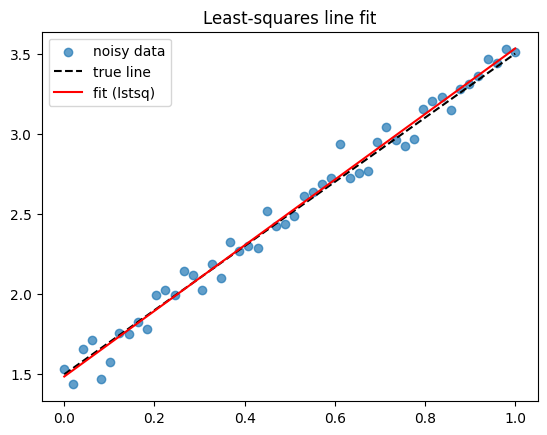

In [ ]:
plt.scatter(xdata, yobs, label="noisy data", alpha=0.7)
plt.plot(xdata, ytrue, 'k--', label="true line")
plt.plot(xdata, A @ coef, 'r-', label="fit (lstsq)")
plt.legend()
plt.title("Least-squares line fit")
plt.show()

## ערכים עצמיים, וקטורים עצמיים, עקבה ודטרמיננטה

למטריצה $A$ מתקבלים **ערכים עצמיים** $\lambda_i$ ו־**וקטורים עצמיים** $v_i$ כך ש־

$$
A v_i = \lambda_i v_i .
$$

### אינטואיציה פיסיקלית
בפיסיקה, ערכים ווקטורים עצמיים מופיעים בהקשרים רבים:
- **מצבים נורמליים** במערכות לינאריות — למשל תנודות קטנות סביב נקודת שיווי משקל.
- **כיווני יציבות/אי־יציבות** במערכות דינמיות.
- **צירים עיקריים** של התפלגות או קירוב קוודרטי (principal axes).

* `np.linalg.eig(A)` מחזירה `(w, V)`:
  - `w` – מערך הערכים העצמיים.
  - `V` – מטריצה שבה כל עמודה היא וקטור עצמי מתאים.
* `np.linalg.eigvals(A)` מחזירה רק את הערכים העצמיים.

במקרה של מטריצה **סימטרית** (או הרמיטית ממשית), מתקיים:
* הערכים העצמיים ממשיים.
* הווקטורים העצמיים ניתנים לבחירה כאורתונורמליים (זווית ישרה ונורמה 1).
* לשימוש כזה עדיף `np.linalg.eigh`, המנצל את מבנה הסימטריה ומחזיר תוצאה יציבה יותר.

### קשרים שימושיים
* העקבה (trace) של מטריצה היא סכום הערכים העצמיים:
  $$
  \mathrm{trace}(A) = \sum_i \lambda_i
  $$
* הדטרמיננטה (det) היא מכפלת הערכים העצמיים:
  $$
  \det(A) = \prod_i \lambda_i
  $$


In [ ]:
# Symmetric example: prefer eigh
A = np.array([[4., 1., 0.],
              [1., 3., 1.],
              [0., 1., 2.]], dtype=float)

w, V = np.linalg.eigh(A)     # sorted ascending
trA = np.trace(A)
detA = np.linalg.det(A)

trace_vs_sum = trA, np.sum(w)
det_vs_prod   = detA, np.prod(w)

# Check orthonormality and reconstruction A ≈ V diag(w) V^T
Icheck = V.T @ V
Arec = V @ np.diag(w) @ V.T
np.allclose(Icheck, np.eye(3)), np.allclose(Arec, A), trace_vs_sum, det_vs_prod


In [ ]:
# Non-symmetric example: complex eigenvalues are possible
B = np.array([[0., -1.],
              [1.,  0.]])
wB, VB = np.linalg.eig(B)
wB, VB


## SVD – פירוק לערכים סינגולריים
ה-SVD מפרק מטריצה  $A$ ל$U\Sigma V^T$, כאשר $\Sigma$ מכילה ערכים סינגולריים אי-שליליים מסודרים מהגדול לקטן. שימושים:

דחיסת מידע/הפחתת מימד -

ניתוח מצבים דומיננטיים -

- least-squares יציב נומרית.

להדגמה נבצע SVD על תמונה (או על מטריצה מלאכותית אם ספריות חיצוניות לא זמינות).

In [ ]:
# Try loading a demo image; fall back to a synthetic image if SciPy is unavailable
try:
    from scipy.datasets import face  # SciPy >= 1.10
    img = face()
except Exception:
    # Simple synthetic "image": gradient + circle
    Y, X = np.ogrid[:256, :256]
    circle = (np.hypot(X-128, Y-128) < 90).astype(float)
    grad = (X / X.max())[None, :]
    img_gray_syn = 0.6*grad + 0.4*circle
    img = np.stack([img_gray_syn, img_gray_syn, img_gray_syn], axis=-1)

# Convert to grayscale using standard luminance weights
img = img.astype(float)
img = img / (img.max() if img.max() > 1 else 255.0)
img_gray = img @ np.array([0.2126, 0.7152, 0.0722])

# SVD
U, s, Vt = np.linalg.svd(img_gray, full_matrices=False)
U.shape, s.shape, Vt.shape, float(s[0]), float(s[-1])


In [ ]:
# Low-rank approximation via top-k singular values
k = 25  # play with k
approx = (U[:, :k] * s[:k]) @ Vt[:k, :]

plt.figure()
plt.title("SVD approximation with k components")
plt.imshow(approx)
plt.axis("off")
plt.show()

# Energy captured by top-k singular values
energy = np.cumsum(s**2) / np.sum(s**2)
energy_k = energy[k-1]
error_rel = np.linalg.norm(img_gray - approx) / np.linalg.norm(img_gray)
energy_k, error_rel


In [ ]:
מחולל אקראי מודרני: np.random.default_rng

לשימוש עדכני ומומלץ באקראיות:

צור מחולל: rng = np.random.default_rng(seed) (סיד קבוע לשחזור).

דגימות נפוצות: rng.uniform, rng.normal, rng.poisson, rng.binomial, rng.choice, ועוד.

וקטוריזציה: דוגמים מערכים גדולים בבת אחת בלי לולאות פייתון.

In [ ]:
# Reproducibility demo: same seed -> same stream
rng1 = np.random.default_rng(123)
rng2 = np.random.default_rng(123)
np.allclose(rng1.normal(size=5), rng2.normal(size=5))


In [ ]:
# Basic distributions
u = rng.uniform(size=10)                      # Uniform [0,1)
z = rng.normal(loc=0.0, scale=1.0, size=10_000)  # Standard normal
p = rng.poisson(lam=3.0, size=10_000)         # Poisson(λ=3)
b = rng.binomial(n=10, p=0.3, size=10_000)    # Binomial
u[:5], z.mean(), z.std(ddof=1), p.mean(), b.mean()


In [ ]:
# Multivariate normal (useful for correlated noise)
mu = np.array([0.0, 0.0])
Sigma = np.array([[1.0, 0.8],
                  [0.8, 1.5]])
X = rng.multivariate_normal(mu, Sigma, size=5_000)
X.shape, np.mean(X, axis=0), np.cov(X.T)


In [ ]:
# Multivariate normal (useful for correlated noise)
mu = np.array([0.0, 0.0])
Sigma = np.array([[1.0, 0.8],
                  [0.8, 1.5]])
X = rng.multivariate_normal(mu, Sigma, size=5_000)
X.shape, np.mean(X, axis=0), np.cov(X.T)


In [ ]:
# Quick histograms (separate figures)
plt.figure()
plt.title("Normal(0,1) – empirical")
plt.hist(z, bins=50, density=True)
plt.xlabel("x"); plt.ylabel("density")
plt.show()

plt.figure()
plt.title("Poisson(λ=3) – empirical")
plt.hist(p, bins=np.arange(p.min(), p.max()+1)-0.5, density=True)
plt.xlabel("k"); plt.ylabel("probability")
plt.show()


תהליך פואסוני – זמני הגעה (Exponential interarrivals)

In [ ]:
# Poisson process via exponential interarrival times
lam = 2.0  # events per unit time
n_events = 2000
inter = rng.exponential(scale=1/lam, size=n_events)  # mean 1/λ
times = np.cumsum(inter)
times[:5], inter.mean()


In [ ]:
# Histogram of interarrival times ~ Exponential(λ)
plt.figure()
plt.title("Poisson process interarrival times")
plt.hist(inter, bins=50, density=True)
plt.xlabel("Δt"); plt.ylabel("density")
plt.show()


## דוגמה מסכמת (1): הערכת מונטה–קרלו של π

הרעיון: לדגום \(N\) נקודות אחידות בריבוע \([-1,1]\times[-1,1]\),  
ולחשב את החלק מהן שנמצא בתוך מעגל היחידה.  

\[
\hat{\pi} \;=\; 4 \cdot \frac{\#\{(x,y): x^2+y^2 \le 1\}}{N}.
\]

בפועל נשתמש במחולל אקראי מודרני ונראה שהשגיאה יורדת בקצב סדר גודל של \(1/\sqrt{N}\).


In [2]:
def mc_pi(N, seed=None):
    # Monte-Carlo estimate of pi using hit/miss in unit disk
    r = np.random.default_rng(seed)
    xy = r.uniform(-1.0, 1.0, size=(N, 2))
    inside = (xy[:,0]**2 + xy[:,1]**2) <= 1.0
    return 4.0 * inside.mean()

Ns = np.logspace(2, 6, num=9, base=10, dtype=int)
est = np.array([mc_pi(int(N), seed=123) for N in Ns])
abs_err = np.abs(est - np.pi)

Ns, est[:5], abs_err[:5]


NameError: name 'np' is not defined

In [ ]:
plt.figure()
plt.title("π estimate vs N (log scale)")
plt.plot(Ns, est, marker='o', label="estimate")
plt.axhline(np.pi, linestyle='--', label="π (true)")
plt.xscale('log')
plt.xlabel("N")
plt.ylabel("estimate")
plt.legend()
plt.show()

plt.figure()
plt.title("|error| vs N (expected ~ 1/√N)")
plt.loglog(Ns, abs_err, marker='o')
plt.xlabel("N")
plt.ylabel("|error|")
plt.show()


## דוגמה מסכמת (2): דיפוזיה בהליכת-אקראי 1D

נבצע \(M\) הליכות אקראיות באורך \(T\) צעדים.  
בכל צעד מתקיים:
\[
x_{t+1} \;=\; x_t + \xi_t, \qquad \xi_t \in \{-1, +1\}, \quad P(\xi_t=+1)=P(\xi_t=-1)=\tfrac{1}{2}.
\]

בממוצע אנליטי מתקבל:
\[
\mathrm{MSD}(t) = \mathbb{E}[\,x_t^2\,] \;\propto\; t.
\]

נראה זאת נומרית, וכן נבדוק את התפלגות נקודת הסיום לאחר \(T\) צעדים — הצפויה להתקרב להתפלגות נורמלית לפי משפט הגבול המרכזי.


In [ ]:
def random_walk_1d(T, M, seed=None):
    # Vectorized ±1 steps and cumulative sums
    r = np.random.default_rng(seed)
    steps = r.choice([-1, 1], size=(M, T))
    x = np.cumsum(steps, axis=1)
    return x

T = 1000
M = 10_000
X = random_walk_1d(T=T, M=M, seed=123)

# Mean-squared displacement over time
msd = (X**2).mean(axis=0)

T, M, msd[:5]


In [ ]:
# MSD ~ t (linear scaling)
t = np.arange(1, T+1)

plt.figure()
plt.title("1D Random Walk – MSD(t) ~ t")
plt.plot(t, msd, label="MSD (empirical)")
# Linear guide normalized to the last point
guide = msd[-1] * (t / t[-1])
plt.plot(t, guide, linestyle='--', label="~linear guide")
plt.xlabel("t")
plt.ylabel("MSD")
plt.legend()
plt.show()


התפלגות נקודת הסיום וה-CLT (התכנסות לנורמלית)

In [ ]:
# Endpoint distribution after T steps should be ~ Normal(0, T)
endpoints = X[:, -1]
mu_hat, var_hat = endpoints.mean(), endpoints.var(ddof=1)

plt.figure()
plt.title("Endpoints histogram ~ N(0, T)")
plt.hist(endpoints, bins=60, density=True)
plt.xlabel("x_T"); plt.ylabel("density")
plt.show()

mu_hat, var_hat, "theory var ~ T =", T
